In [1]:
# autoload changes in imported modules
%load_ext autoreload
%autoreload 2

# vscode theme magic
%load_ext vscode_magic
from time import time
import numpy as np
from tqdm.notebook import trange, tqdm
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import jax
import jax.numpy as jnp
from jax import grad, vmap
from jax.scipy.stats import norm
import equinox as eqx
import jax.nn as jnn
import jax.sharding as jsh
from jax.experimental import checkify
from plots import *
from decoders import *

%matplotlib inline
# %config InlineBackend.figure_format='svg'
%config InlineBackend.figure_format='retina'

trange = partial(trange, bar_format="{bar}", leave=False)
tqdm = partial(tqdm, bar_format="{bar}", leave=False)

# "iridis" color map (viridis without the deep purple)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
iridis = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1)

#jax.config.update('jax_num_cpu_devices', 8)

Running on the cluster across multiple machines:

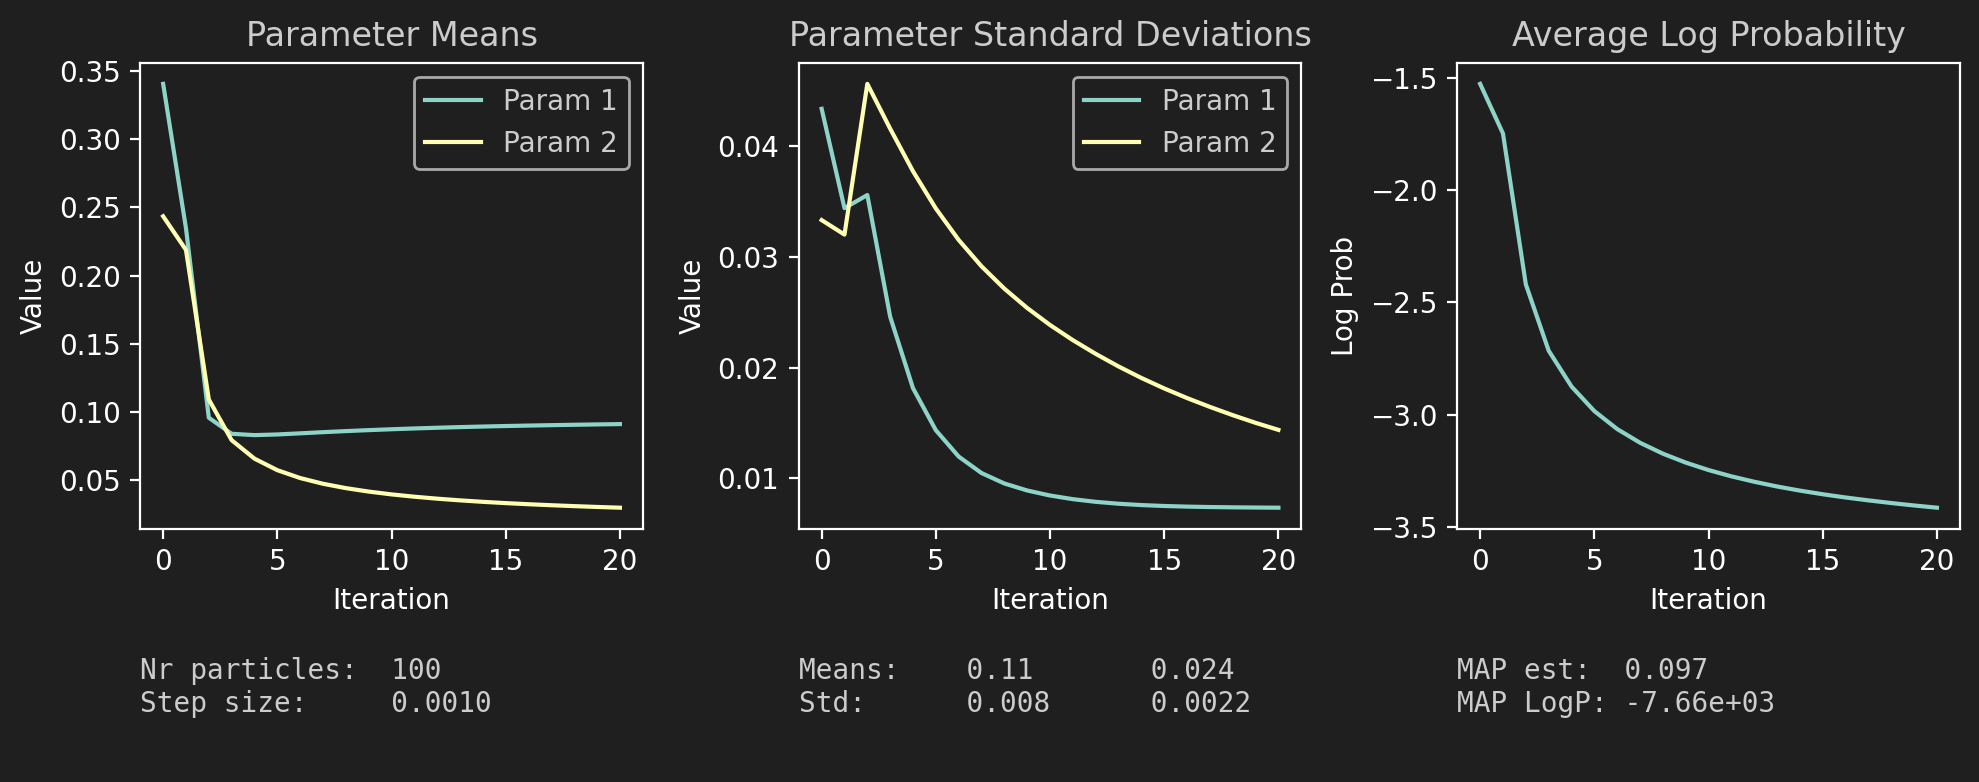

In [108]:
@jax.jit
def example_ptd_spec(a, b):
    alpha = jnp.array([1.0, 0.0])
    T = jnp.array([[1-a-b, a],
                    [0.0, 1-a]])
    t1 = jnp.array([b, a])
    t_vecs = [t1] 
    return alpha, T, t_vecs


def simulate_example_data(a, b, samples=None, key=None):

    if key is None:
        key = jax.random.key(int(time() * 1e6))

    alpha, T, t_vecs = example_ptd_spec(a, b)

    m = T.shape[0]

    k = len(t_vecs)
    t_vecs_stacked = jnp.stack(t_vecs, axis=0)  # shape (k, m)

    def single_sample(key):
        key, subkey = jax.random.split(key)
        state = jax.random.choice(subkey, m, p=alpha)
        t_vec = jnp.zeros(k, dtype=int)

        def cond_fn(carry):
            _, _, _, absorbed = carry
            return ~absorbed

        def body_fn(carry):
            key, state, t, _ = carry
            key, *subkeys = jax.random.split(key, num=k + 2)

            draws = jnp.array([
                jax.random.uniform(subkeys[i]) < t_vecs_stacked[i, state]
                for i in range(k)
            ])
            absorbed = jnp.any(draws)

            # update discrete events if not absorbed
            t_new = jax.lax.cond(absorbed, lambda t_: t_, lambda t_: t_ + 1, t)

            state_new = jax.lax.cond(
                absorbed,
                lambda s: s,
                lambda s: jax.random.choice(subkeys[-1], m, p=T[s]),
                operand=state
            )

            return key, state_new, t_new, absorbed

        init_carry = (key, state, jnp.zeros(k, dtype=int), False)
        _, _, t_final, _ = jax.lax.while_loop(cond_fn, body_fn, init_carry)
        return t_final

    keys = jax.random.split(key, samples)
    return jax.vmap(single_sample)(keys)

@jax.jit
def unpack_theta(theta):
    # no vector or matrix variables, so just return values as list
    return tuple([jnp.array(x) for x in theta])

@jax.jit
def log_pmf_dph(z, theta):
    """
    Fully static version for JIT compilation
    """
    a, b = theta

    alpha, T, t_vecs = example_ptd_spec(a, b)


    m = T.shape[0]
    k = len(t_vecs)

    # Use fixed upper bound
    z_max = 50
    t_mat = jnp.stack(t_vecs, axis=1)  # shape (m, k)

    def body_fun(i, carry):
        Tk, probs = carry
        out = alpha @ Tk @ t_mat
        Tk_next = Tk @ T
        return Tk_next, probs.at[i].set(out)

    Tk0 = jnp.eye(m)
    probs_init = jnp.zeros((z_max, k))
    _, probs_filled = jax.lax.fori_loop(0, z_max, body_fun, (Tk0, probs_init))

    # Ensure z is properly shaped and clipped
    z_clipped = jnp.clip(z.astype(int), 0, z_max - 1)
    
    # Use a fully vectorized approach without conditionals
    # Pad z_clipped to always have k elements (for univariate case)
    z_padded = jnp.pad(z_clipped, (0, max(0, k - len(z_clipped))))[:k]
    
    # Use advanced indexing with static shapes
    indices = jnp.arange(k)
    prob_at_z = probs_filled[z_padded, indices]
    logp = jnp.sum(jnp.log(jnp.maximum(prob_at_z, 1e-12)))
    
    return logp

# Use adaptive kernel bandwidth
@jax.jit
def median_heuristic(particles):
    """Compute bandwidth using median heuristic"""
    pairwise_dist = jnp.sum((particles[:, None, :] - particles[None, :, :])**2, axis=-1)
    h = jnp.median(pairwise_dist) / (2 * jnp.log(particles.shape[0] + 1))
    return h

# Local bandwidth adjustment: For highly multimodal distributions, consider
# using particle-specific bandwidths that adapt to local density:
@jax.jit
def local_adaptive_bandwidth(particles, k=5):
    """Compute local bandwidth for each particle based on k nearest neighbors"""
    # Compute pairwise distances
    pairwise_dist = jnp.sum((particles[:, None, :] - particles[None, :, :])**2, axis=-1)
    
    # For each particle, find distance to k-th nearest neighbor
    sorted_dist = jnp.sort(pairwise_dist, axis=1)
    kth_neighbor_dist = sorted_dist[:, k]

    # Set bandwidth proportional to distance to k-th neighbor
    local_h = kth_neighbor_dist / (2 * jnp.log(k + 1))
    return local_h

# Batch-based bandwidth estimation: For very large datasets, compute the
# bandwidth using a random subset of the data to improve computational
# efficiency:
@jax.jit
def batch_median_heuristic(particles, max_particles=1000):
    """Compute bandwidth using a subset of particles for large sample sizes"""
    if len(particles) > max_particles:
        idx = np.random.choice(len(particles), max_particles, replace=False)
        particles_subset = particles[idx]
    else:
        particles_subset = particles
        
    pairwise_dist = jnp.sum((particles_subset[:, None, :] - particles_subset[None, :, :])**2, axis=-1)
    h = jnp.median(pairwise_dist) / (2 * jnp.log(max_particles + 1))
    return h

# @jax.jit
def svgd_update_adaptive_bandwidth(particles, grad_log_prob, neighbors, step_size):
    """
    Vectorized implementation of SVGD with adaptive bandwidth
    
    Args:
        particles: array of shape (n_particles, dim)
        grad_log_prob: function that computes gradient of log probability
        step_size: learning rate for the update
        
    Returns:
        Updated particles after one SVGD step
    """
    

    # Compute local bandwidths for each particle
    local_bandwidths = local_adaptive_bandwidth(particles, k=neighbors)

    # Compute gradients of log probability for all particles
    log_prob_grads = jax.vmap(grad_log_prob)(particles)
    
    # Number of particles
    n_particles = particles.shape[0]
    
    # Compute pairwise differences between particles: (n_particles, n_particles, dim)
    pairwise_diff = particles[:, None, :] - particles[None, :, :]
    
    # Compute pairwise squared distances: (n_particles, n_particles)
    pairwise_dist_sq = jnp.sum(pairwise_diff**2, axis=-1)
    
    # Compute average bandwidths between all pairs: (n_particles, n_particles)
    h_matrix = 0.5 * (local_bandwidths[:, None] + local_bandwidths[None, :])



    # Compute kernel matrix: (n_particles, n_particles)
    kernel_matrix = jnp.exp(-0.5 * pairwise_dist_sq / h_matrix)
    
    # Compute kernel-weighted average of gradients (kernel term)
    # (n_particles, n_particles, 1) * (n_particles, 1, dim) -> (n_particles, n_particles, dim)
    kernel_term = kernel_matrix[:, :, None] * log_prob_grads[None, :, :]
    
    # Sum over particles j: (n_particles, dim)
    kernel_term_sum = jnp.sum(kernel_term, axis=1) / n_particles
    
    # Compute gradient of kernel w.r.t. particles (repulsive term)
    # (n_particles, n_particles, 1) * (n_particles, n_particles, dim) / (n_particles, n_particles, 1)
    grad_kernel = kernel_matrix[:, :, None] * pairwise_diff / h_matrix[:, :, None]
    
    # Sum over particles j: (n_particles, dim)
    repulsive_term_sum = jnp.sum(grad_kernel, axis=1) / n_particles
    
    # Combine terms for the SVGD update
    phi = kernel_term_sum + repulsive_term_sum
    


    # Update particles
    updated_particles = particles + step_size * phi
    
    return updated_particles

# --- RBF Kernel using median heuristic for dynamic h ---
@jax.jit
def rbf_kernel(X, h=-1):
    pairwise_dists = jnp.sum((X[:, None, :] - X[None, :, :])**2, axis=-1)
    # Make bandwidth calculation static to avoid dynamic operations
    h = jnp.where(h <= 0, 
                  jnp.median(pairwise_dists) / jnp.log(X.shape[0] + 1.0),
                  h)
    K = jnp.exp(-pairwise_dists / h)
    grad_K = -2 / h * (X[:, None, :] - X[None, :, :]) * K[:, :, None]
    return K, grad_K

@jax.jit
def logp(theta):
    theta = unpack_theta(theta)
    log_prob = jnp.sum(vmap(lambda x: log_pmf_dph(x, theta))(data))
    return log_prob

@jax.jit
def logp_z(z):
    theta = z_to_theta(z)         
    return jnp.sum(vmap(lambda z_i: log_pmf_dph(z_i, theta))(data))

@jax.jit
def svgd_update_z(particles_z, data, step_size):

    # def logp_z(z):
    #     theta = z_to_theta(z)         
    #     return jnp.sum(vmap(lambda z_i: log_pmf_dph(z_i, theta))(data))
    
    # neighbors = 5  # Number of neighbors for adaptive bandwidth
    # if neighbors is not None:
    #     return svgd_update_adaptive_bandwidth(
    #         particles_z, logp_z, neighbors=neighbors, step_size=step_size)
    
    grads = vmap(grad(logp_z))(particles_z)
    K, grad_K = rbf_kernel(particles_z)
    phi = (K @ grads + jnp.sum(grad_K, axis=1)) / particles_z.shape[0]
    return particles_z + step_size * phi

########################

# # --- RBF Kernel assuming h is passed explicitly and fixed ---
# def rbf_kernel(x, h):
#     pairwise_dists = jnp.sum((x[:, None, :] - x[None, :, :]) ** 2, axis=-1)
#     kxy = jnp.exp(-pairwise_dists / h)
#     dxkxy = -2.0 / h * (x[:, None, :] - x[None, :, :]) * kxy[:, :, None]
#     return kxy, dxkxy

def svgd_phi(logp_fn, particles):
    score = vmap(grad(logp_fn))(particles)
    kxy, dxkxy = rbf_kernel(particles)
    phi = (kxy @ score + jnp.sum(dxkxy, axis=1)) / particles.shape[0]
    return phi

def kl_adaptive_step(phi, kl_target=0.1):
    norm_sq = jnp.sum(phi ** 2, axis=1)
    mean_norm_sq = jnp.mean(norm_sq)
    eta = jnp.sqrt((2.0 * kl_target) / (mean_norm_sq + 1e-8))
    return eta

#@jax.jit
def svgd_fit_kl_step(logp_fn, particles, n_iter=100, kl_target=0.1):
    def body_fn(i, particles):
        phi = svgd_phi(logp_fn, particles)
        eta = kl_adaptive_step(phi, kl_target)
        return particles + eta * phi
    return jax.lax.fori_loop(0, n_iter, body_fn, particles)



@jax.jit
def step_size_schedule(i, steps=None, initial=None, final=None):
    """Cosine annealing schedule for step size"""
    return final + 0.5 * (initial - final) * (1 + jnp.cos(jnp.pi * i / steps))

@jax.jit
def z_to_theta(z):
    global decoder
    # return unpack_theta(z)
    return decoder(z)


# #########################

# # Score function ∇ log p(θ)
# def score_function(x, theta):
#     return grad(log_pmf_dph)(x, theta)

# # Vectorized score function
# batched_score_function = vmap(score_function, in_axes=(0, None))  # over particles

# # SVGD update step with concatenated batch
# def svgd_update_z(particles, concatenated_batch, step_size=1e-2):
#     n_particles, dim = particles.shape
#     scores = batched_score_function(particles, concatenated_batch)  # [n, d]
    
#     K, h = rbf_kernel(particles)
#     grad_K = -2 / h * (particles[:, None, :] - particles[None, :, :]) * K[:, :, None]  # [n, n, d]
    
#     phi = (K @ scores + jnp.sum(grad_K, axis=0)) / n_particles
#     return particles + step_size * phi

# # Simulate 3 minibatches and concatenate
# batch1 = jax.random.normal(_key, (64, d))
# batch2 = jax.random.normal(_key, (64, d))
# batch3 = jax.random.normal(_key, (64, d))
# concatenated_batch = jnp.concatenate([batch1, batch2, batch3], axis=0)


# #########################

# decoder = None  # Global variable to hold the decoder instance
# particles = None  # Global variable to hold the final particles
# particle_history = None  # Global variable to hold the history of particles

# def run_svgd():

    # global decoder, particles, particle_history

key = jax.random.key(0)

a, b = 0.1, 0.02 # True parameters for the PTD
theta = [a, b]

# example_data
_data = simulate_example_data(*theta, samples=2048, key=key)


##########

# import jax
# import jax.numpy as jnp
# from jax.sharding import NamedSharding, PartitionSpec
# from jax.experimental import mesh_utils
# from jax.experimental.pjit import pjit

# # Set parameters
# n_devices = jax.device_count()
# batch_size = 128
# features = 32
# assert batch_size % n_devices == 0

# # Fake data
# x = jnp.arange(batch_size * features).reshape((batch_size, features))

# # Reshape for sharding: [n_devices, batch_per_device, features]
# x_reshaped = x.reshape(n_devices, batch_size // n_devices, features)

# @pjit
# def model_step(x):
#     return x ** 2

# # Define sharding
# mesh = mesh_utils.create_device_mesh((n_devices,))
# with jax.sharding.Mesh(mesh, ('d',)):
#     sharding = NamedSharding(jax.sharding.Mesh(mesh, ('d',)), PartitionSpec('d', None, None))
#     x_sharded = jax.device_put(x_reshaped, sharding)

#     print(f"x_sharded shape: {x_sharded.shape}, sharding: {x_sharded.sharding}")

#     result = model_step(x_sharded)
#     result = result.ravel()

# print(result.shape)

##########

# # shard for parallel processing
# nr_cpus = 8
# batch_size = 100
# nr_batches = _data.shape[0] // (nr_cpus * batch_size) 
# print(nr_batches * nr_batches * nr_cpus)
# _data = _data[:nr_batches * nr_batches * nr_cpus].reshape(nr_batches, batch_size, nr_cpus)
# devices = jax.devices("cpu")[:8]  # assume at least 8 CPU devices
# mesh = jsh.Mesh(devices, axis_names=("cpu",))
# # Shard over 16 logical shards -> 'logical_cpu_shard' axis
# # This uses the same 8 physical devices repeatedly
# sharding = jsh.NamedSharding(mesh, jsh.PartitionSpec("cpu", None, None))
# # Reshape into 16 shards before device_put
# data = jax.device_put(_data, sharding)

##########

# mesh = jax.make_mesh((8, 1), ('i', 'j'))
# sharding = jsh.NamedSharding(mesh, jsh.PartitionSpec('i', 'j'))
# data = jax.device_put(_data, sharding)

# assert data.shape == _data.shape

# for shard in data.addressable_shards:
#     print(shard.index, shard.device, shard.data.shape)

##########

data = _data

##########

n_particles = 100
n_iter = 200
step_size = 0.001

decoder = IndependentProbDecoder(latent_dim=2, key=key) # used by z_to_theta
particles_z = jax.random.uniform(key, shape=(n_particles, len(theta)), minval=0, maxval=1)



particles_z = svgd_fit_kl_step(logp_z, particles_z, n_iter=200, kl_target=0.1)


def svgd_fit(logp_fn, particles, n_iter=100, step=0.001):
    def body_fn(i, particles):
        grads = vmap(grad(logp_fn))(particles_z)
        K, grad_K = rbf_kernel(particles_z)
        phi = (K @ grads + jnp.sum(grad_K, axis=1)) / particles_z.shape[0]
        return particles_z + step * phi
    return jax.lax.fori_loop(0, n_iter, body_fn, particles)

# particles_z = svgd_fit(logp_z, particles_z, n_iter=200, step=0.001)


# particle_z_history = [particles_z]
# step = step_size
# for i in trange(n_iter):
#     # step = step_size_schedule(i, steps=n_iter, initial=0.002, final=0.0001)
#     particles_z = svgd_update_z(particles_z, data, step)
#     if not i % 10:
#         particle_z_history.append(particles_z)
# particle_history = np.array([vmap(lambda z: z_to_theta(z))(p) for p in particle_z_history])
# particle_z_history = np.array(particle_z_history)
# # jax.debug.print("🤯 {}", particles_z)




# particles = vmap(lambda z: z_to_theta(z))(particles_z)
particles = jnp.array([z_to_theta(z) for z in particles_z])

p1, p2 = 0, 1
map_point, map_log_prob = map_estimate_from_particles(particles, logp)
a_mean = jnp.mean(particles[:, p1], axis=0)
b_mean = jnp.mean(particles[:, p2], axis=0)
a_std = jnp.std(particles[:, p1], axis=0)
b_std = jnp.std(particles[:, p2], axis=0)
text = [
    '\n'.join([
        f"{'Nr particles:'.ljust(15)}{n_particles:<10}",
        f"{'Step size:'.ljust(15)}{step_size:<10.4f}",
    ]),
    '\n'.join([
        f"{'Means:'.ljust(10)}{a_mean:<10.2} {b_mean:<10.2}", 
        f"{'Std:'.ljust(10)}{a_std:<10.2} {b_std:<10.2}", 
    ]),
    '\n'.join([
        f"{'MAP est:'.ljust(10)}{map_point[p1]:<10.2}",
        f"{'MAP LogP:'.ljust(10)}{map_log_prob:<10.2e}"
    ]),
]

check_convergence(particle_history, log_pmf_dph, data, text=text)

In [91]:
# Create and save animation. Maybe skip first couple frames to shrink plotted range.
animate_svgd_2d(particle_history, true_params=[a, b], skip=0)

### Add check to see if param means start jumping and reduce h if so

In [4]:
# def logp_z(z):
#     theta = z_to_theta(z)
#     alpha, T, t_vecs = unpack_theta(theta)
#     return jnp.sum(vmap(lambda x: log_pmf_dph(x, alpha, T, t_vecs))(data))

# def logp(theta):
#     theta = unpack_theta(theta)
#     log_prob = jnp.sum(vmap(lambda x: log_pmf_dph(x, theta))(data))
#     return log_prob

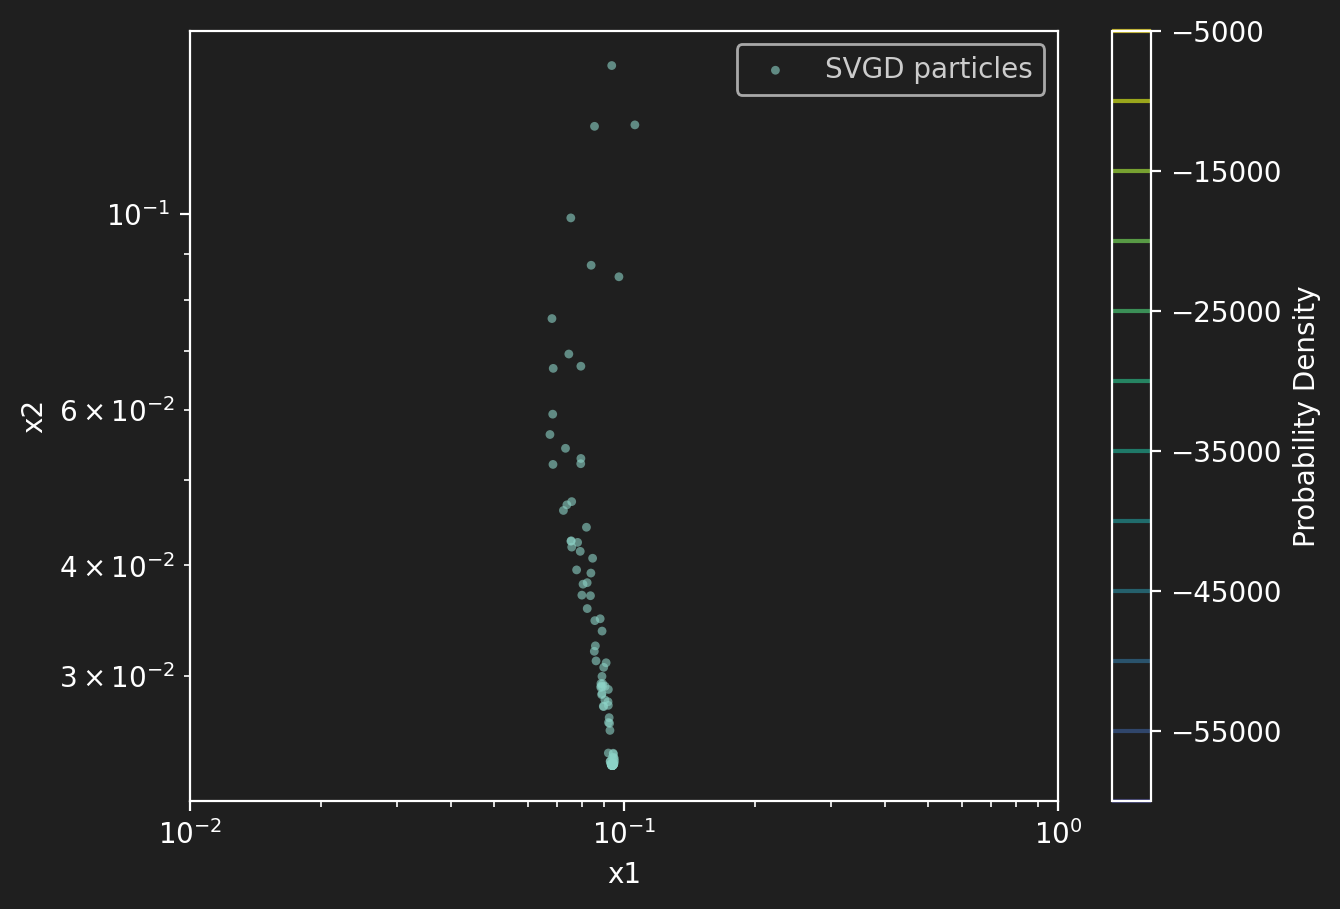

In [5]:
idx = [0, 1]

# Visualize results
plt.figure(figsize=(7, 5))

plt.gca().set(xscale="log", yscale="log")

# a, b = particles[:, idx[0]], particles[:, idx[1]]
a_part, b_part = particles[:, 0], particles[:, 1]


# Plot final particles
plt.scatter(a_part, b_part, s=10, alpha=0.6, edgecolor='none', label='SVGD particles')

# Generate contour plot of the target distribution
resolution = 50
x = jnp.logspace(-2, 0, resolution)
y = jnp.linspace(-2, 0, resolution)
X, Y = jnp.meshgrid(x, y)
pos = jnp.stack([X.flatten(), Y.flatten()], axis=1)
# vmap expects a function that takes a single argument, so wrap log_prob accordingly
# You need to use the correct log probability function for your model.
# In your notebook, the function is named `logp_z`, and it expects a vector of shape (d,)
# But your grid points are 2D, while your model's latent space is higher-dimensional (d=8).
# For visualization, you should select two dimensions (e.g., the first two) and fix the rest.

theta_mean = jnp.mean(particles, axis=0)

# We'll fix the remaining dimensions to their mean values from theta_mean:
def logp_2d(p):
    # p: shape (2,)
    z = theta_mean.at[idx[0]].set(p[0]).at[idx[1]].set(p[1]) 
    return logp(z)

# Z = jnp.exp(vmap(logp_2d)(pos)).reshape(X.shape)
Z = vmap(logp_2d)(pos).reshape(X.shape)

plt.contour(X, Y, Z, levels=10, cmap=iridis, alpha=0.7)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
# plt.grid(alpha=0.3) 
plt.colorbar(label='Probability Density')


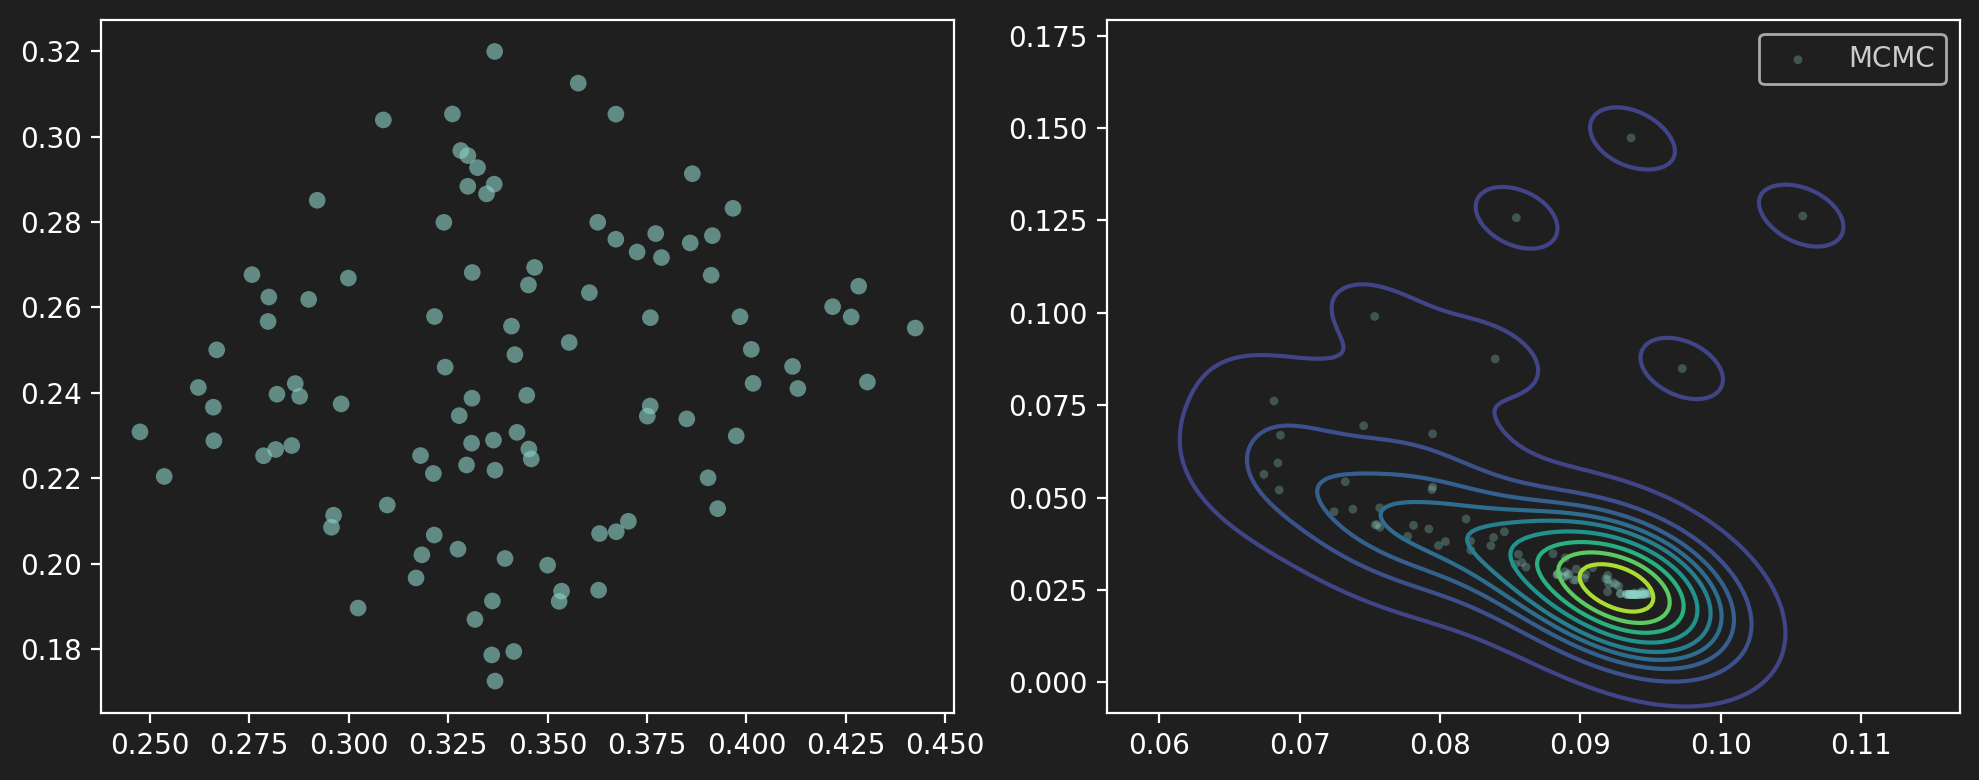

In [6]:

# Plot results
plt.figure(figsize=(10, 4))

# Plot initial particles
a_init, b_init = particle_history[0]
plt.subplot(1, 2, 1)
plt.scatter(a_init, b_init, edgecolor='none', alpha=0.6, label='Initial')
# plt.grid(alpha=0.3)

# # Plot reference samples
# plt.subplot(1, 3, 2)
# # plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], edgecolor='none', alpha=0.3, s=10, label='MCMC')
# sns.scatterplot(x=X[:,  idx[0]], y=X[:,  idx[1]], edgecolor='none', alpha=0.3, s=10, label='MCMC')
# sns.kdeplot(x=X[:,  idx[0]], y=X[:,  idx[1]], cmap=iridis)    
# plt.title('Initial particles')
# plt.title('Samples')
# # plt.grid(alpha=0.3)

# Plot final SVGD particles
a_final, b_final = particles[:, idx[0]], particles[:, idx[1]]
plt.subplot(1, 2, 2)
# plt.scatter(a, b, edgecolor='none', alpha=0.6, label='Initial')

# _, _, final = vmap(lambda z: z_to_theta(z))(particle_history[-1])
sns.scatterplot(x=a_final, y=b_final, edgecolor='none', alpha=0.3, s=10, label='MCMC')
sns.kdeplot(x=a_final, y=b_final, cmap=iridis)    
# plt.scatter(final_particles[:, 0], final_particles[:, 1], edgecolor='none', alpha=0.6, label='SVGD')
# plt.title('SVGD with Copula Transform')
# plt.grid(alpha=0.3)

plt.tight_layout()

MAP estimate: [0.09402448 0.02373292], log probability: -7662.0927734375
HDR contains 95 particles out of 100
HDR log probability threshold: -7983.974609375


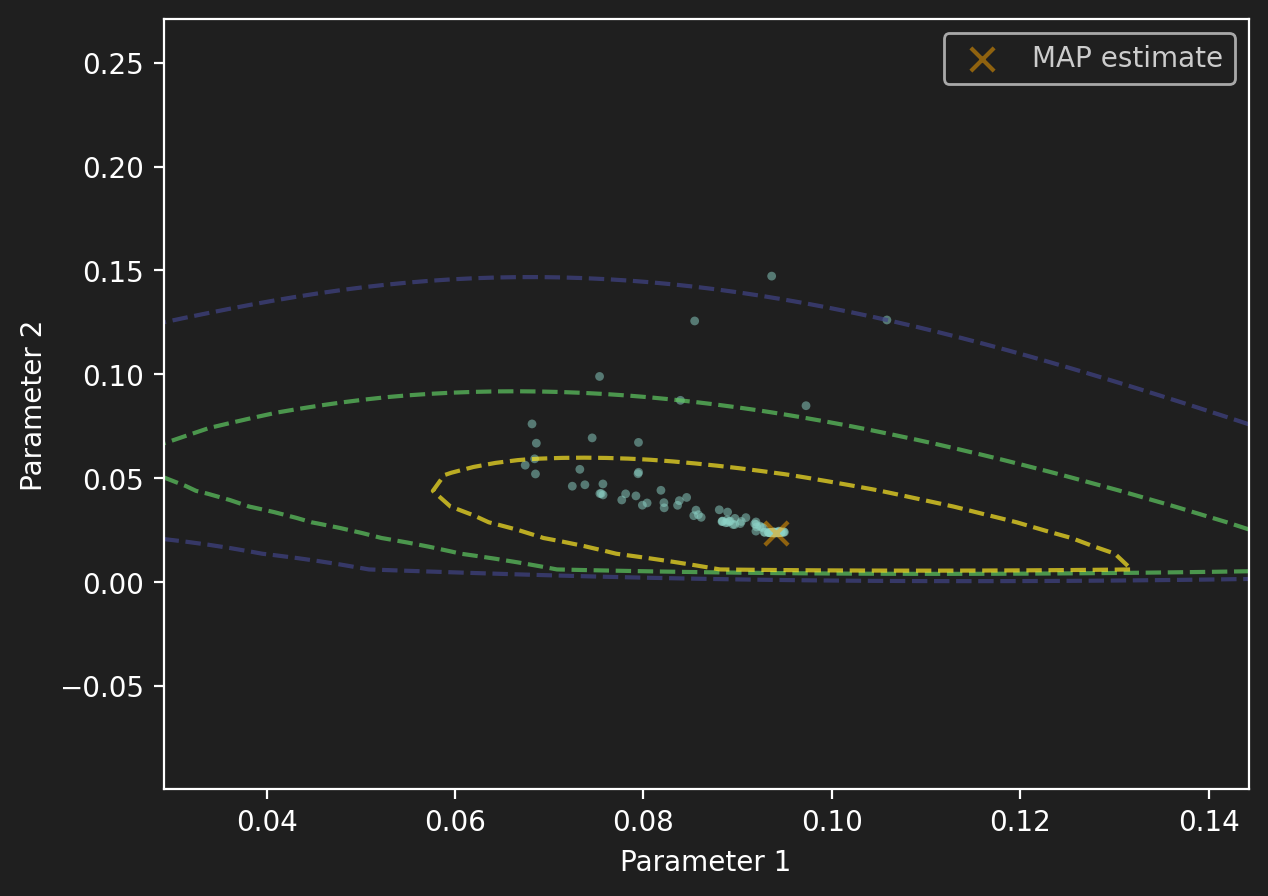

In [7]:


# Find MAP estimate
map_point, map_log_prob = map_estimate_from_particles(particles, logp)
print(f"MAP estimate: {map_point}, log probability: {map_log_prob}")

# # Refine with optimization
# refined_map, refined_log_prob = map_estimate_with_optimization(particles, logp)
# print(f"Refined MAP: {refined_map}, log probability: {refined_log_prob}")

# Get HDR
hdr_particles, threshold = estimate_hdr(particles, logp, alpha=0.95)
print(f"HDR contains {len(hdr_particles)} particles out of {len(particles)}")
print(f"HDR log probability threshold: {threshold}")

alphas=[0.90, 0.95, 0.99]
# idx = [0, 1]  # Indices of the dimensions to visualize

def logp(theta):
    return jnp.sum(vmap(lambda x: log_pmf_dph(x, theta))(data))

fig = visualize_hdr_2d(particles, logp, idx=[0, 1], grid_size=50, 
                       alphas=alphas, margin=1)


In [5]:
int(time() * 1e6)

NameError: name 'time' is not defined

In [6]:
# def rand_key():

#     seed = jax.random.randint(minval=0, maxval=100000, shape=1, key=key)
#     return jax.random.key(seed.item())
jax.random.key(int(time() * 1e6))


NameError: name 'jax' is not defined

In [7]:

[simulate_example_data(*p, samples=10, key=None) for p in particles]


NameError: name 'particles' is not defined

In [84]:
simulate_example_data(0.1, 0.02, samples=10, key=None)

Array([[21],
       [ 5],
       [ 8],
       [ 6],
       [ 5],
       [35],
       [14],
       [26],
       [38],
       [40]], dtype=int32)

In [86]:
for p in particles:
    print(simulate_example_data(*p, samples=10, key=None).squeeze())

[ 6 22 11 17  2 12  3  6  4  5]
[10 16 45 24 25 18  7 16  9 25]
[ 8  6 25  4 28 21  8 10 14  5]
[26 11 12  9 18 11 29  1 15 43]
[ 8  5  8 11  9 15 20 19 24 45]
[11 21 60 51 20 26 40 12 10  7]
[17 26  1 11 17  5 15 17  0  2]
[30 14 21 15  5 23  3  9  4 12]
[17 29 16 30  4 13  0 14 29  2]
[19 20  5  0  6 29  5 14  9 20]
[10 23 24 23  9  6 19  8 26 18]
[25 39  9 42 19  4 10 49 28  4]
[10 24 18  1 22 12 11 19 20 27]
[ 9 11 16 18  7  3 26 10 20  4]
[ 9 48  3  0 21 43  1 46 26  0]
[19 13 10  2 17  6  1  8 11  6]
[23  0 12 13 17 36 26 35  0  8]
[11  8 10  8  5 11  6 17 18 12]
[ 7  0  9 23 17 19 22  1 30 15]
[33  4 12 12 12  9  0  9  2 12]
[ 3  3 27 23 17  8 29 23  2 23]
[44 35 20  2 30 31  7 36  8  0]
[63 13  7  8 23  4  0 31  1  5]
[29  7  3  2 20  2  5 38  4  2]
[9 6 3 5 9 4 0 6 9 6]
[44  4 19 20  7 35  1 34 17 11]
[ 6 20  8  6 22  2 19 16 17 44]
[23 23 16  0 18  4  4 23 25 13]
[ 5 18  6 17 16  6  9  9 15 10]
[19 25 19 22 27 18  2 21 25 10]
[10 16 17  8 14 14  1 20  6  7]
[10 26  7 20  9  0

In [87]:
vmap(lambda p: simulate_example_data(*p, samples=10, key=None), in_axes=0)(particles).squeeze()

Array([[23, 18,  0, 13,  6, 15, 14, 14, 24, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  0, 13,  6, 15, 14, 14, 24, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 15, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 15, 14, 14, 24, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 15, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 56, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 13,  6, 67, 14, 14, 20, 43],
       [23, 18,  6, 

[0.1, 0.02]


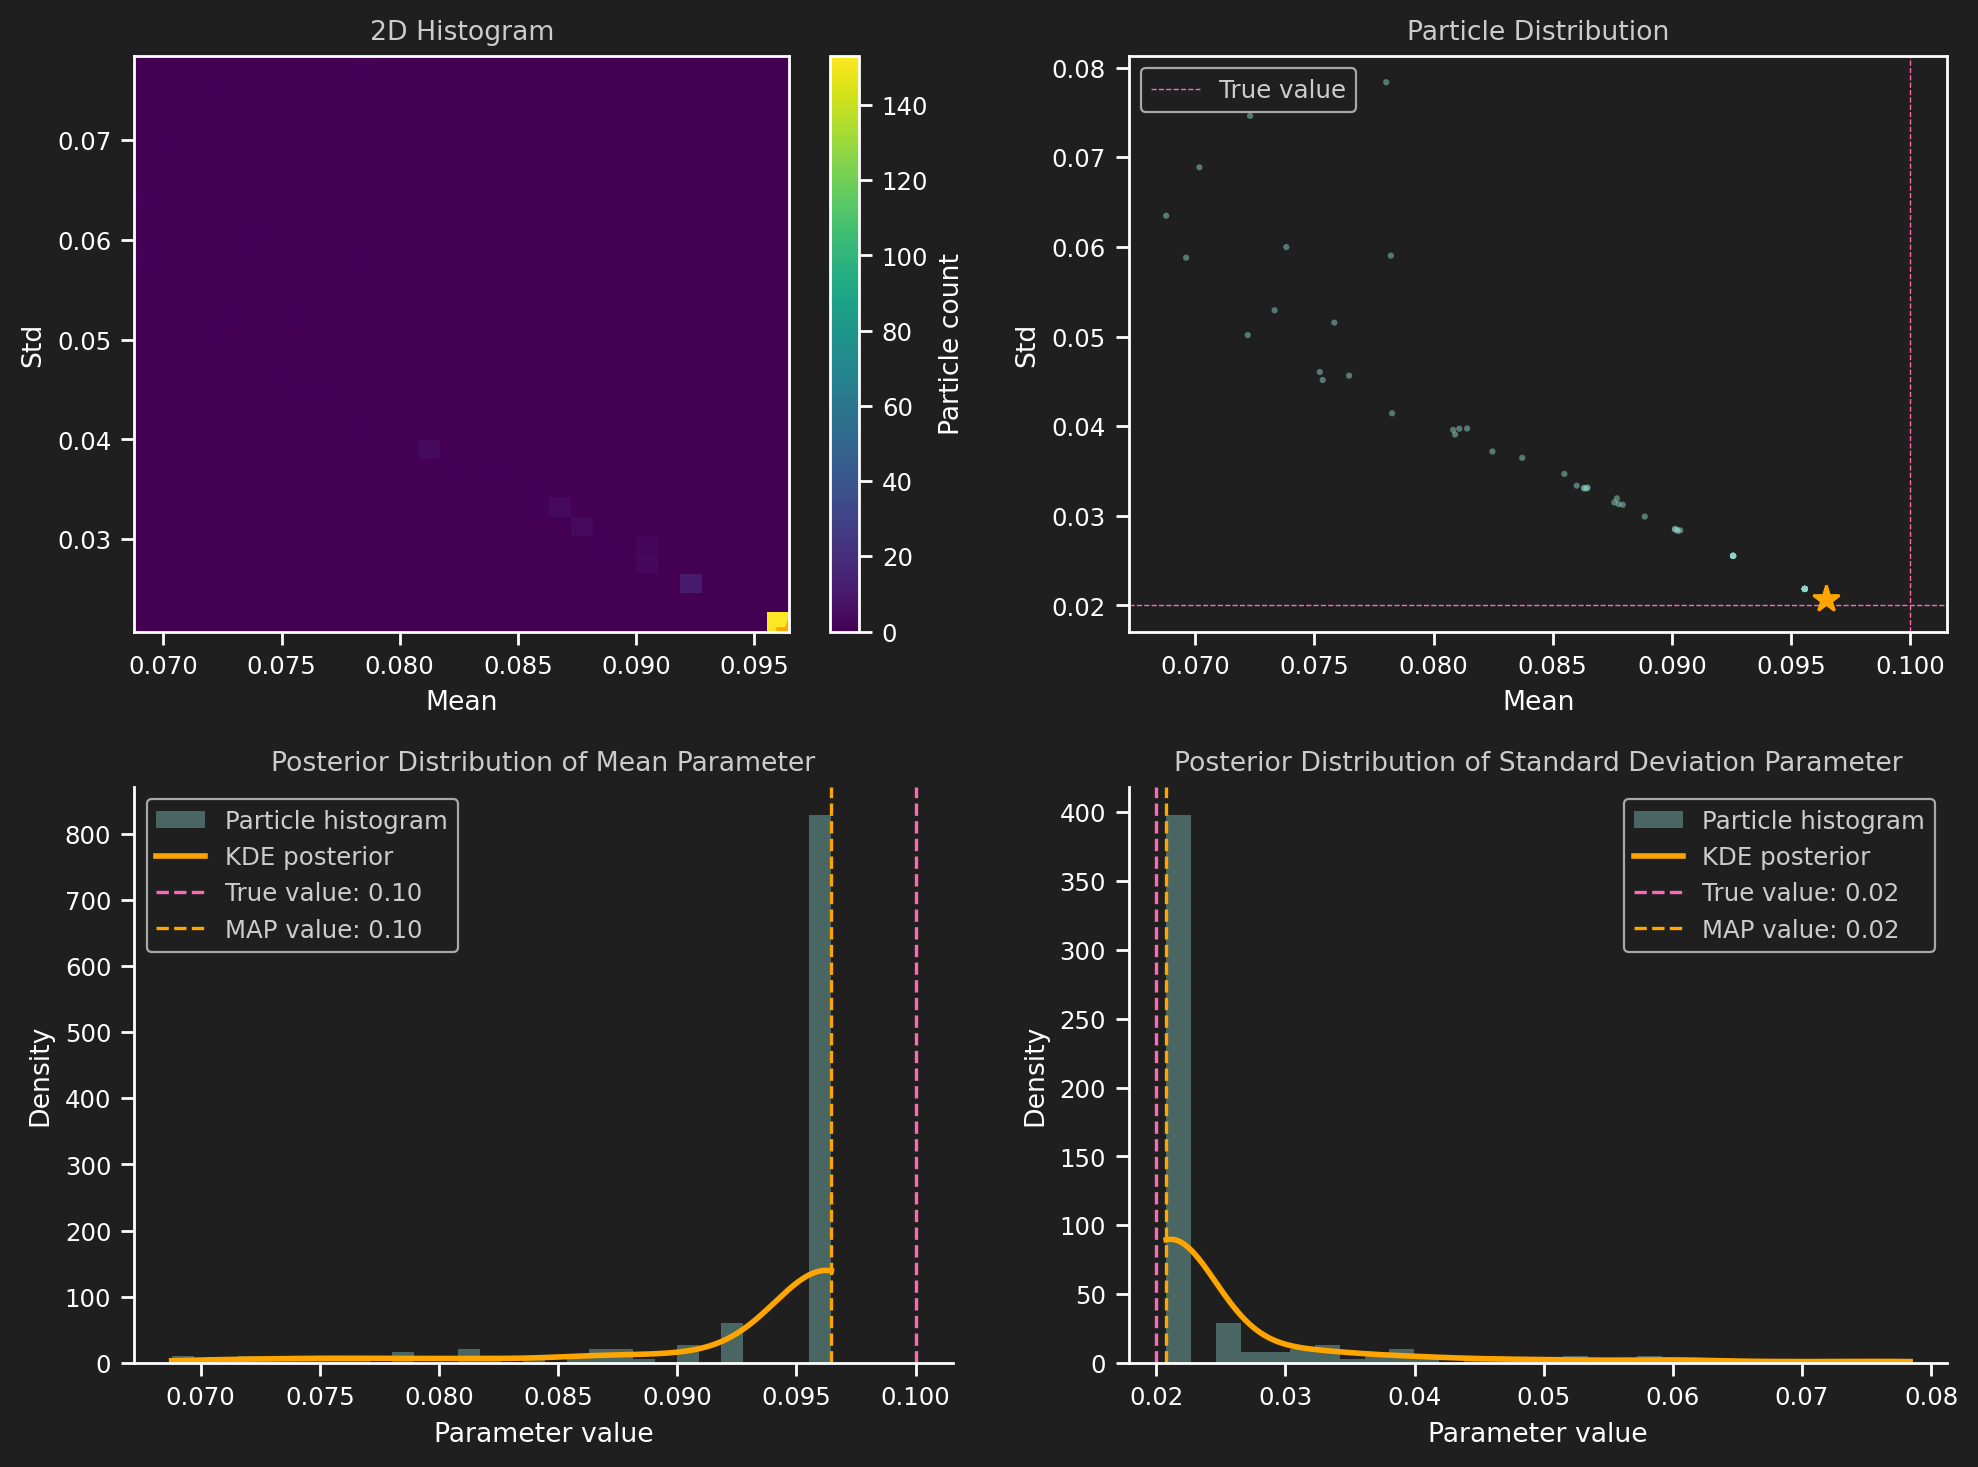

In [45]:
sns.set_context('paper')
# Plot the final posterior approximation
plot_svgd_posterior_2d(
    particles,  # Convert to numpy if using JAX arrays
    true_params=[a, b],  # True parameters that generated the data
    # obs_stats=[data[:, 0].mean(), data[:, 1].std()],
    map_est=map_point.tolist(),
    labels=["Mean", "Std"],
)

## example of vectorized computation

In [ ]:
def svgd_update_with_adaptive_bandwidth_vectorized(particles, grad_log_prob, neighbors, step_size):
    """
    Vectorized implementation of SVGD with adaptive bandwidth
    
    Args:
        particles: array of shape (n_particles, dim)
        grad_log_prob: function that computes gradient of log probability
        step_size: learning rate for the update
        
    Returns:
        Updated particles after one SVGD step
    """
    

    # Compute local bandwidths for each particle
    local_bandwidths = local_adaptive_bandwidth(particles, k=neighbors)

    # Compute gradients of log probability for all particles
    log_prob_grads = jax.vmap(grad_log_prob)(particles)
    
    # Number of particles
    n_particles = particles.shape[0]
    
    # Compute pairwise differences between particles: (n_particles, n_particles, dim)
    pairwise_diff = particles[:, None, :] - particles[None, :, :]
    
    # Compute pairwise squared distances: (n_particles, n_particles)
    pairwise_dist_sq = jnp.sum(pairwise_diff**2, axis=-1)
    
    # Compute average bandwidths between all pairs: (n_particles, n_particles)
    h_matrix = 0.5 * (local_bandwidths[:, None] + local_bandwidths[None, :])

    # Compute kernel matrix: (n_particles, n_particles)
    kernel_matrix = jnp.exp(-0.5 * pairwise_dist_sq / h_matrix)
    
    # Compute kernel-weighted average of gradients (kernel term)
    # (n_particles, n_particles, 1) * (n_particles, 1, dim) -> (n_particles, n_particles, dim)
    kernel_term = kernel_matrix[:, :, None] * log_prob_grads[None, :, :]
    
    # Sum over particles j: (n_particles, dim)
    kernel_term_sum = jnp.sum(kernel_term, axis=1) / n_particles
    
    # Compute gradient of kernel w.r.t. particles (repulsive term)
    # (n_particles, n_particles, 1) * (n_particles, n_particles, dim) / (n_particles, n_particles, 1)
    grad_kernel = kernel_matrix[:, :, None] * pairwise_diff / h_matrix[:, :, None]
    
    # Sum over particles j: (n_particles, dim)
    repulsive_term_sum = jnp.sum(grad_kernel, axis=1) / n_particles
    
    # Combine terms for the SVGD update
    phi = kernel_term_sum + repulsive_term_sum
    
    # Update particles
    updated_particles = particles + step_size * phi
    
    return updated_particles